In [1]:
import finnhub
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.optimize as sco
import math
import random
import pickle
import numba

def get_df(ticker, days):
    now = round(time.time())
    day = 60*60*24

    from_ = now - days * day
    to = now

    candles = client.stock_candles(ticker, "D", from_, to, _preload_content=False).data
    try:
        df = pd.read_json(candles)
        df.index = df["t"]
        return df
    except:
        print(candles)


In [2]:
with open("/home/bill/stockbot_2020/finnhub_key.txt", "r") as key_file:
    config = finnhub.Configuration(
        api_key={
            "token": key_file.readline()
        }
    )

client = finnhub.DefaultApi(finnhub.ApiClient(config))

In [3]:
# finviz = pd.read_hdf("/home/bill/stockbot_2020/data/vol500k/finviz.h5")
# tickers = []
# while len(tickers) != 30:
#     tickers = [random.choice(finviz.index) for _ in range(30)]
with open("/home/bill/stockbot_2020/data/stocks_only/groups.pkl", "rb") as groups_file:
    groups = pickle.load(groups_file)

tickers = groups[max(groups.keys())]

In [4]:
separate_returns = []
for symbol in tqdm(tickers):
    candles = get_df(symbol, 365*1)
    candles.index = candles["t"]
    separate_returns.append(np.log(candles["c"]/candles["c"].shift(1)))
returns = pd.concat(separate_returns, axis=1)
returns.columns = tickers
returns.fillna(value=0, inplace=True)

100%|██████████| 42/42 [00:14<00:00,  2.86it/s]


In [12]:
def kelly(w, x):
    w_sum = np.abs(w).sum()
    # w_sum = np.sum(np.abs(w))
    w = np.true_divide(w, w_sum)
    x = np.dot(x, w)
    x_mean = np.mean(x)
    x_std = np.std(x)
    x_var = np.square(x_std)
    return -np.true_divide(x_mean, x_std)
    # return -x.mean() / x.std()**2


In [12]:
# w = np.random.normal(size=len(tickers))
# res = sco.minimize(kelly, w, bounds=[(0, 1)] * len(w))
# print(res.x / res.x.sum())
# print(kelly(res.x))

In [15]:

# period_lengths = [round(7 * i**1.7) for i in range(1, 11)]
# test_returns = [[] for i in range(10)]
test_returns = []
base_returns = []
pbar = tqdm(range(30, len(returns)))
base_pos = np.ones(len(tickers)) / len(tickers)
for i in pbar:
    visible = returns.iloc[:i]
    # for i in range(len(test_returns)):
    w = np.random.normal(size=len(tickers))
    # period_length = period_lengths[i]
    period_length = 7
    history = visible[-period_length:]
    x = sco.minimize(lambda w: kelly(w, history), w, bounds=[(-1, 1)] * len(w)).x
    pos = (x / np.abs(x).sum()) * 0.999
    if sum(pos) > 1:
        print("Position greater than 1", sum(pos))
        exit()
    test_returns.append(sum(returns.iloc[i] * pos))
    base_returns.append(sum(returns.iloc[i] * base_pos))
test_returns = np.exp(np.array(test_returns).cumsum())
base_returns = np.exp(np.array(base_returns).cumsum())
        

100%|██████████| 223/223 [06:31<00:00,  1.76s/it]


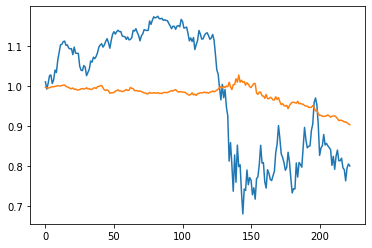

In [16]:
plt.plot(base_returns)
plt.plot(test_returns)
plt.show()